##Deep learning for the time series


**Numerous timeseries task types**

##An example of temperature forecasting

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-07 20:09:38--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.212.48, 54.231.231.96, 16.182.69.240, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.212.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  34.9MB/s    in 0.4s    

2024-04-07 20:09:39 (34.9 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Studying the Jena weather dataset's data**


In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()

lines_data_data = data.split("\n")
header = lines_data_data[0].split(",")
lines_data_data= lines_data_data[1:]
print(header)
print(len(lines_data_data))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Analyzing the information**

In [6]:
!pip install numpy

In [11]:
import numpy as np

In [12]:
temperature = np.zeros((len(lines_data_data),))
raw_data = np.zeros((len(lines_data_data), len(header) - 1))
for i, line in enumerate(lines_data_data):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the time series of temperature**

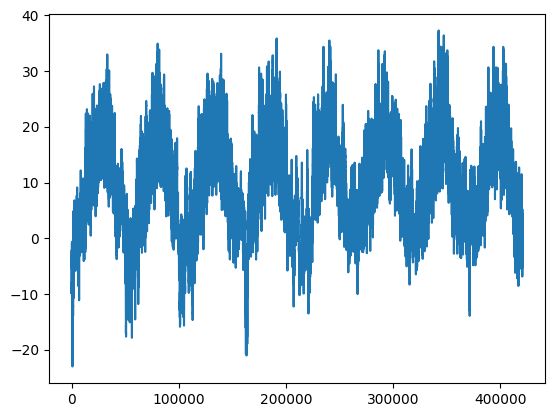

In [13]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the temperature timeseries for the initial 10 days**

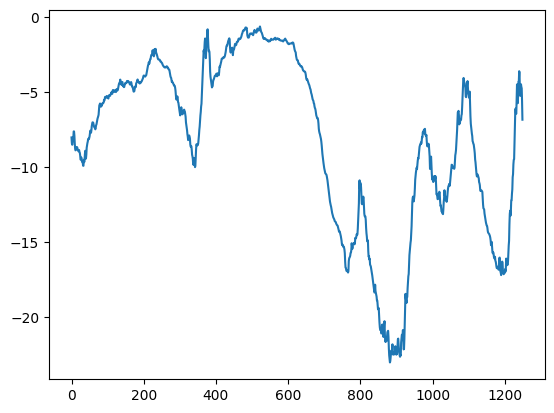

In [14]:
plt.plot(range(1250), temperature[:1250])


**Calculating out how many samples we utilise for every data split**

In [15]:
num_training_samples = int(0.2 * len(raw_data))
num_validation_samples = int(0.15 * len(raw_data))
num_test_samples = len(raw_data) - num_training_samples - num_validation_samples
print("num_training_samples:", num_training_samples)
print("num_validation_samples:", num_validation_samples)
print("num_test_samples:", num_test_samples)


num_training_samples: 84090
num_validation_samples: 63067
num_test_samples: 273294


##Preparing the Data

Normalizing the Data

In [17]:
mean = raw_data[:num_training_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_training_samples].std(axis=0)
raw_data /= std
import numpy as np
from tensorflow import keras
initial_sequence = np.arange(10)
dummy_data = keras.utils.timeseries_dataset_from_array(
data=initial_sequence[:-2],
targets=initial_sequence[2:],
sequence_length=4,
batch_size=1,
)
for inputs, targets in dummy_data:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2, 3] 2
[1, 2, 3, 4] 3
[2, 3, 4, 5] 4
[3, 4, 5, 6] 5
[4, 5, 6, 7] 6


**Developing datasets in real time for testing, validation, and training**

In [18]:
sampling_rate = 4
sequence_length = 80
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 128

training_dataset = keras.utils.timeseries_dataset_from_array(
raw_data[:-delay],
targets=temperature[delay:],
sampling_rate=sampling_rate,
sequence_length=sequence_length,
shuffle=True,
batch_size=batch_size,
start_index=0,
end_index=num_training_samples)

validation_dataset = keras.utils.timeseries_dataset_from_array(
raw_data[:-delay],
targets=temperature[delay:],
sampling_rate=sampling_rate,
sequence_length=sequence_length,
shuffle=True,
batch_size=batch_size,
start_index=num_training_samples,
end_index=num_training_samples + num_validation_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
raw_data[:-delay],
targets=temperature[delay:],
sampling_rate=sampling_rate,
sequence_length=sequence_length,
shuffle=True,
batch_size=batch_size,
start_index=num_training_samples + num_validation_samples)

**Examining the output of one of our datasets**

In [19]:
for samples, targets in training_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break


samples shape: (128, 80, 14)
targets shape: (128,)


##A sensible, non-machine-learning baseline

Calculating the sensible baseline MAE


In [21]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen
print(f"Validation MAE: {evaluate_naive_method(validation_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")


Validation MAE: 4.53
Test MAE: 4.08


##Let us attempt a simple machine-learning model

**Utilizing a tightly connected model through training and assessment**

In [22]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_dense.x",
save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
epochs=10,
validation_data=validation_dataset,
callbacks=callbacks)
model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
655/655 [==============================] - 24s 35ms/step - loss: 11.3950 - mae: 2.5707 - val_loss: 9.7297 - val_mae: 2.4735
Epoch 2/10
655/655 [==============================] - 20s 30ms/step - loss: 7.3463 - mae: 2.1258 - val_loss: 11.6832 - val_mae: 2.7249
Epoch 3/10
655/655 [==============================] - 24s 36ms/step - loss: 6.7285 - mae: 2.0360 - val_loss: 9.5312 - val_mae: 2.4503
Epoch 4/10
655/655 [==============================] - 20s 31ms/step - loss: 6.3394 - mae: 1.9733 - val_loss: 10.0457 - val_mae: 2.4907
Epoch 5/10
655/655 [==============================] - 23s 34ms/step - loss: 6.0823 - mae: 1.9351 - val_loss: 9.9473 - val_mae: 2.4935
Epoch 6/10
655/655 [==============================] - 23s 34ms/step - loss: 5.9037 - mae: 1.9061 - val_loss: 9.7822 - val_mae: 2.4737
Epoch 7/10
655/655 [==============================] - 21s 32ms/step - loss: 5.7188 - mae: 1.8762 - val_loss: 9.8263 - val_mae: 2.4752
Epoch 8/10
655/655 [==============================] - 20s 3

**Plotting the results**

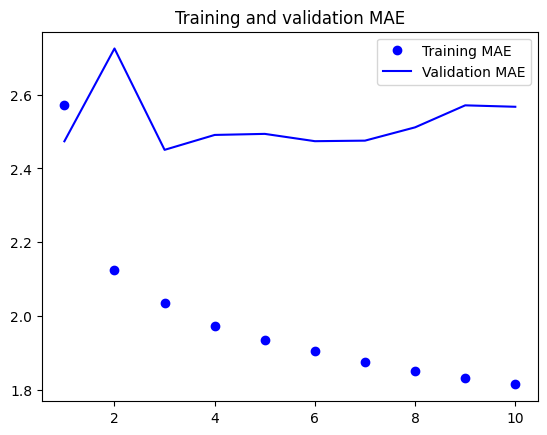

In [23]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
validation_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, validation_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()


##Attempting a try to  1D convolutional model

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_conv.x",
save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
epochs=10,
validation_data=validation_dataset,
callbacks=callbacks)
model = keras.models.load_model("jena_conv.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
655/655 [==============================] - 32s 46ms/step - loss: 14.7395 - mae: 2.9227 - val_loss: 11.8752 - val_mae: 2.6896
Epoch 2/10
655/655 [==============================] - 32s 49ms/step - loss: 9.0614 - mae: 2.3545 - val_loss: 10.7291 - val_mae: 2.5646
Epoch 3/10
655/655 [==============================] - 29s 44ms/step - loss: 8.2258 - mae: 2.2422 - val_loss: 11.1684 - val_mae: 2.6210
Epoch 4/10
655/655 [==============================] - 30s 45ms/step - loss: 7.7019 - mae: 2.1710 - val_loss: 11.1841 - val_mae: 2.6072
Epoch 5/10
655/655 [==============================] - 31s 47ms/step - loss: 7.3335 - mae: 2.1217 - val_loss: 10.8455 - val_mae: 2.5453
Epoch 6/10
655/655 [==============================] - 29s 45ms/step - loss: 7.0385 - mae: 2.0813 - val_loss: 11.9560 - val_mae: 2.7121
Epoch 7/10
655/655 [==============================] - 43s 66ms/step - loss: 6.8033 - mae: 2.0483 - val_loss: 13.3366 - val_mae: 2.8545
Epoch 8/10
655/655 [==============================] - 

##An initial recurring baseline

**A basic model based on LSTM**

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_lstm.x",
save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
epochs=10,
validation_data=validation_dataset,
callbacks=callbacks)
model = keras.models.load_model("jena_lstm.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
655/655 [==============================] - 51s 75ms/step - loss: 50.5629 - mae: 5.2006 - val_loss: 16.9839 - val_mae: 3.1898
Epoch 2/10
655/655 [==============================] - 46s 69ms/step - loss: 11.6069 - mae: 2.5661 - val_loss: 11.1847 - val_mae: 2.6380
Epoch 3/10
655/655 [==============================] - 49s 75ms/step - loss: 8.0824 - mae: 2.1860 - val_loss: 10.9593 - val_mae: 2.5955
Epoch 4/10
655/655 [==============================] - 45s 69ms/step - loss: 7.2100 - mae: 2.0680 - val_loss: 11.1543 - val_mae: 2.6098
Epoch 5/10
655/655 [==============================] - 56s 86ms/step - loss: 6.7754 - mae: 2.0062 - val_loss: 10.9749 - val_mae: 2.5833
Epoch 6/10
655/655 [==============================] - 44s 67ms/step - loss: 6.3417 - mae: 1.9439 - val_loss: 11.8966 - val_mae: 2.6807
Epoch 7/10
655/655 [==============================] - 51s 78ms/step - loss: 6.0588 - mae: 1.9029 - val_loss: 11.3609 - val_mae: 2.6320
Epoch 8/10
655/655 [==============================] -

##Detecting recurrent neural networks

**An RNN implementation in NumPy**

In [27]:
import numpy as np
timesteps = 50
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

##One of Keras's recurrent layers

**A layer of an RNN capable of handling any length of sequence**

In [28]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)


**An RNN layer that only provides the most recent output step**

In [29]:
num_features = 14
steps = 80
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)


(None, 16)


**A layer of RNN that provides the complete output sequence**

In [30]:
num_features = 14
steps = 80
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)


(None, 80, 16)


**Layer stacking for RNNs**

In [31]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

##Substantial application of recurrent neural networks

##Managing overfitting with recurring dropout

**Training and testing a dropout-regularized long short-term memory (LSTM)**

In [32]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.15)(inputs)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_lstm_dropout.x",
save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
epochs=30,
validation_data=validation_dataset,
callbacks=callbacks)


Epoch 1/30
655/655 [==============================] - 79s 116ms/step - loss: 46.6460 - mae: 5.0230 - val_loss: 15.6712 - val_mae: 3.0919
Epoch 2/30
655/655 [==============================] - 81s 124ms/step - loss: 16.1501 - mae: 3.0617 - val_loss: 11.1307 - val_mae: 2.6333
Epoch 3/30
655/655 [==============================] - 83s 127ms/step - loss: 13.4490 - mae: 2.8216 - val_loss: 10.2204 - val_mae: 2.5055
Epoch 4/30
655/655 [==============================] - 74s 113ms/step - loss: 12.5972 - mae: 2.7258 - val_loss: 10.1979 - val_mae: 2.4934
Epoch 5/30
655/655 [==============================] - 76s 116ms/step - loss: 12.1476 - mae: 2.6785 - val_loss: 10.0998 - val_mae: 2.4759
Epoch 6/30
655/655 [==============================] - 75s 114ms/step - loss: 11.8037 - mae: 2.6454 - val_loss: 9.8226 - val_mae: 2.4522
Epoch 7/30
655/655 [==============================] - 79s 121ms/step - loss: 11.4185 - mae: 2.6018 - val_loss: 10.1755 - val_mae: 2.4968
Epoch 8/30
655/655 [======================

In [34]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(16, recurrent_dropout=0.1, unroll=True)(inputs)

##stacking layers of recurrent

**Training and evaluation of a stacked GRU model with dropout regularization**

In [35]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16, recurrent_dropout=0.2, return_sequences=True)(inputs)
x = layers.GRU(16, recurrent_dropout=0.2)(x)
x = layers.Dropout(0.2 )(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.x",
save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
epochs=30,
validation_data=validation_dataset,
callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/30
655/655 [==============================] - 127s 188ms/step - loss: 43.2997 - mae: 4.7523 - val_loss: 14.9114 - val_mae: 2.9821
Epoch 2/30
655/655 [==============================] - 124s 189ms/step - loss: 13.1333 - mae: 2.7672 - val_loss: 10.6994 - val_mae: 2.5722
Epoch 3/30
655/655 [==============================] - 125s 190ms/step - loss: 10.8614 - mae: 2.5579 - val_loss: 10.0293 - val_mae: 2.4763
Epoch 4/30
655/655 [==============================] - 123s 188ms/step - loss: 10.3191 - mae: 2.5000 - val_loss: 9.6948 - val_mae: 2.4339
Epoch 5/30
655/655 [==============================] - 118s 180ms/step - loss: 9.8812 - mae: 2.4476 - val_loss: 9.8532 - val_mae: 2.4456
Epoch 6/30
655/655 [==============================] - 123s 187ms/step - loss: 9.5483 - mae: 2.4075 - val_loss: 9.4724 - val_mae: 2.3989
Epoch 7/30
655/655 [==============================] - 116s 177ms/step - loss: 9.3022 - mae: 2.3728 - val_loss: 9.6275 - val_mae: 2.4306
Epoch 8/30
655/655 [=====================

##Using RNNs in both directions

**Training and evaluation of a bidirectional LSTM**

In [37]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(8))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
epochs=10,
validation_data=validation_dataset)


Epoch 1/10
655/655 [==============================] - 70s 101ms/step - loss: 57.3354 - mae: 5.6161 - val_loss: 20.3978 - val_mae: 3.5417
Epoch 2/10
655/655 [==============================] - 63s 96ms/step - loss: 13.9892 - mae: 2.8546 - val_loss: 13.9512 - val_mae: 2.9660
Epoch 3/10
655/655 [==============================] - 62s 95ms/step - loss: 9.6417 - mae: 2.4013 - val_loss: 12.1398 - val_mae: 2.7689
Epoch 4/10
655/655 [==============================] - 64s 97ms/step - loss: 8.1547 - mae: 2.2053 - val_loss: 12.0951 - val_mae: 2.7595
Epoch 5/10
655/655 [==============================] - 55s 84ms/step - loss: 7.4348 - mae: 2.1088 - val_loss: 11.8200 - val_mae: 2.7158
Epoch 6/10
655/655 [==============================] - 66s 100ms/step - loss: 6.9947 - mae: 2.0492 - val_loss: 11.7916 - val_mae: 2.7009
Epoch 7/10
655/655 [==============================] - 59s 90ms/step - loss: 6.6781 - mae: 2.0079 - val_loss: 11.9872 - val_mae: 2.7246
Epoch 8/10
655/655 [==============================]